# Opinion dynamics over discourse sheaves

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from scipy.linalg import null_space
from scipy.integrate import solve_ivp

from builder import SheafBuilder
from models import SheafDynamic
from visualization import opinion_trajectory_plot

## Constant sheaves with stalk equal to $\mathbb{R}^n$ on each vertex and node

### Opinion diffusion via Laplacian heat equation 

In [2]:
sheaf = SheafBuilder(7, 4, constant = True)

x0 = sheaf.initial_state()
x_null = sheaf.null_space_projector(x0)

dynamic = SheafDynamic(
    sheaf.L_f, 
    sheaf.B, 
    0.1, 
    0.5, 
    sheaf.edges, 
    sheaf.V, 
    sheaf.d, 
    x0)

In [3]:
trajectories_1 = dynamic.privateOpinionDynamicSolver()

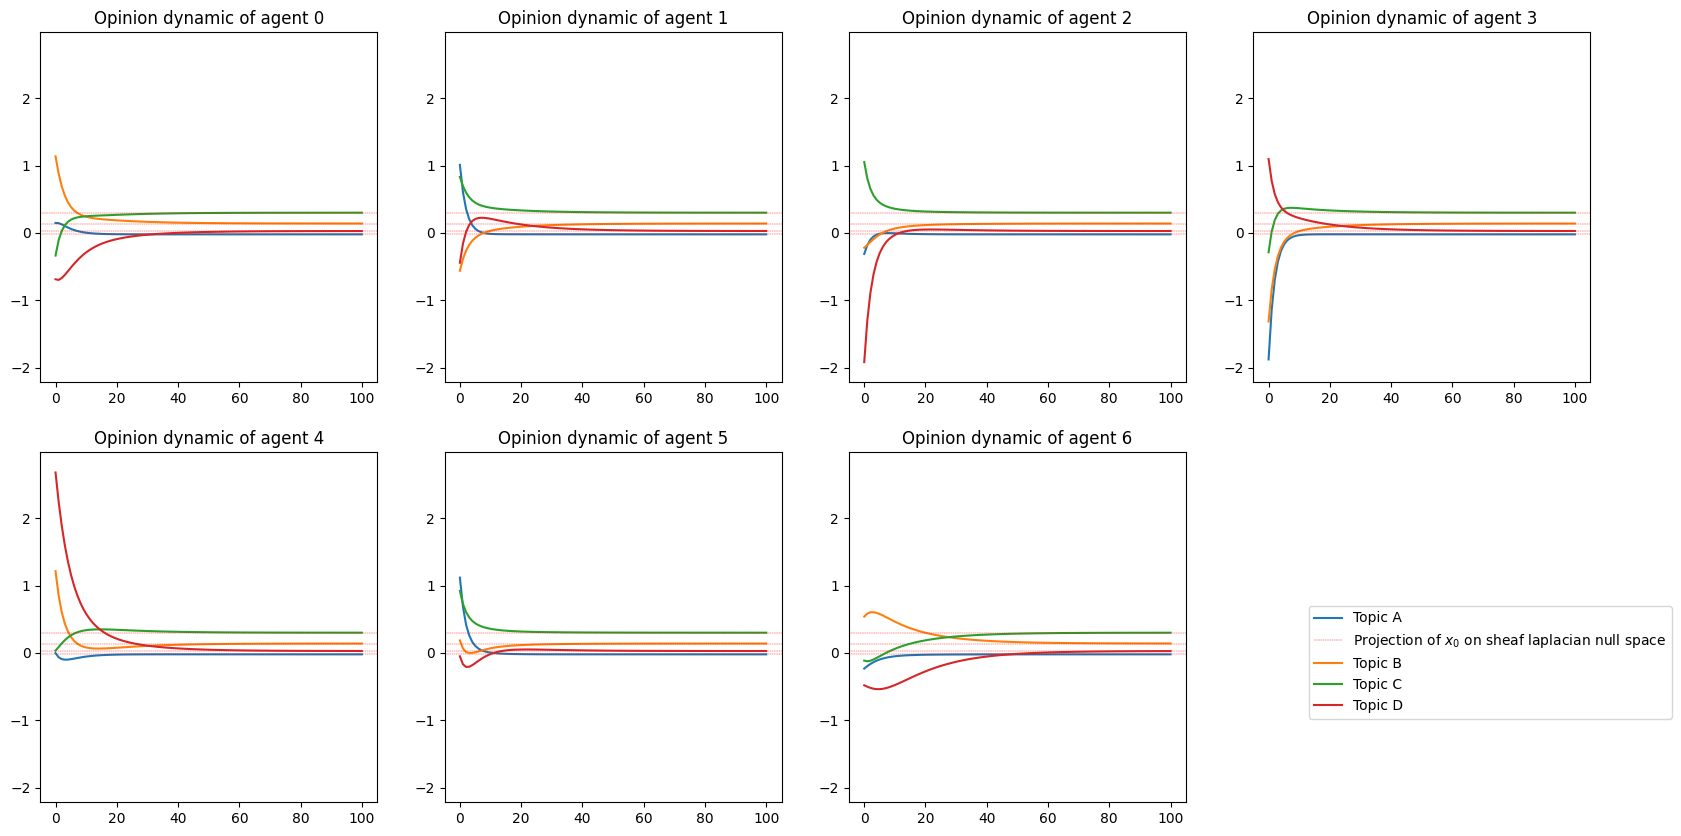

In [4]:
opinion_trajectory_plot(trajectories_1, dynamic.time_points, sheaf.d, range(sheaf.V), x_null)

### Modeling stubborn agents requires just restriction over the dynamics

In [5]:
U = np.random.choice(7, 3, replace = False)
sheaf = SheafBuilder(7, 4, constant = True, stubborn = U)

x0 = sheaf.initial_state()
x_null = sheaf.null_space_projector(x0)

dynamic = SheafDynamic(
    sheaf.L_f, 
    sheaf.B, 
    0.1, 
    0.5, 
    sheaf.edges, 
    sheaf.V, 
    sheaf.d, 
    x0,
    U = U)

In [6]:
trajectories_2 = dynamic.privateOpinionDynamicSolver()

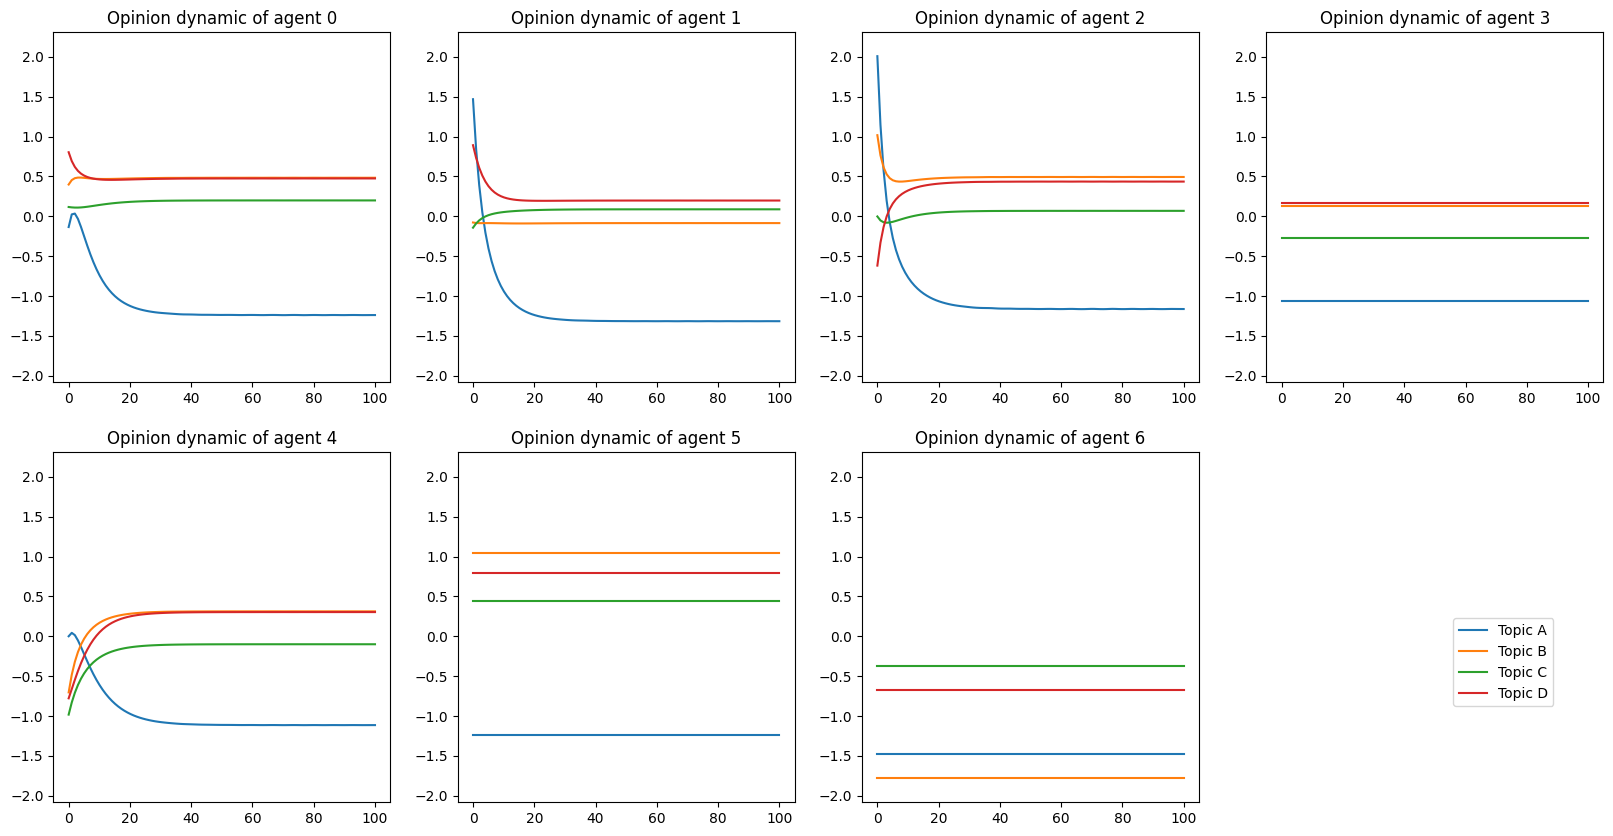

In [7]:
opinion_trajectory_plot(trajectories_2, dynamic.time_points, sheaf.d, range(sheaf.V),)

### Beyond stubborness: forcing opinions 

In [8]:
U = np.random.choice(7, 1, replace = False)
Y = [agent for agent in range(7) if agent not in U]

sheaf = SheafBuilder(7, 4, constant = True, stubborn = U, control = Y)

x0 = sheaf.initial_state()
x_null = sheaf.null_space_projector(x0)

dynamic = SheafDynamic(
    sheaf.L_f, 
    sheaf.B, 
    0.1, 
    0.5, 
    sheaf.edges, 
    sheaf.V, 
    sheaf.d, 
    x0,
    U = U, 
    Y = Y)

In [9]:
U

array([0])

In [10]:
_, trajectories_3 = dynamic.forcingOpinionDynamicSolver()

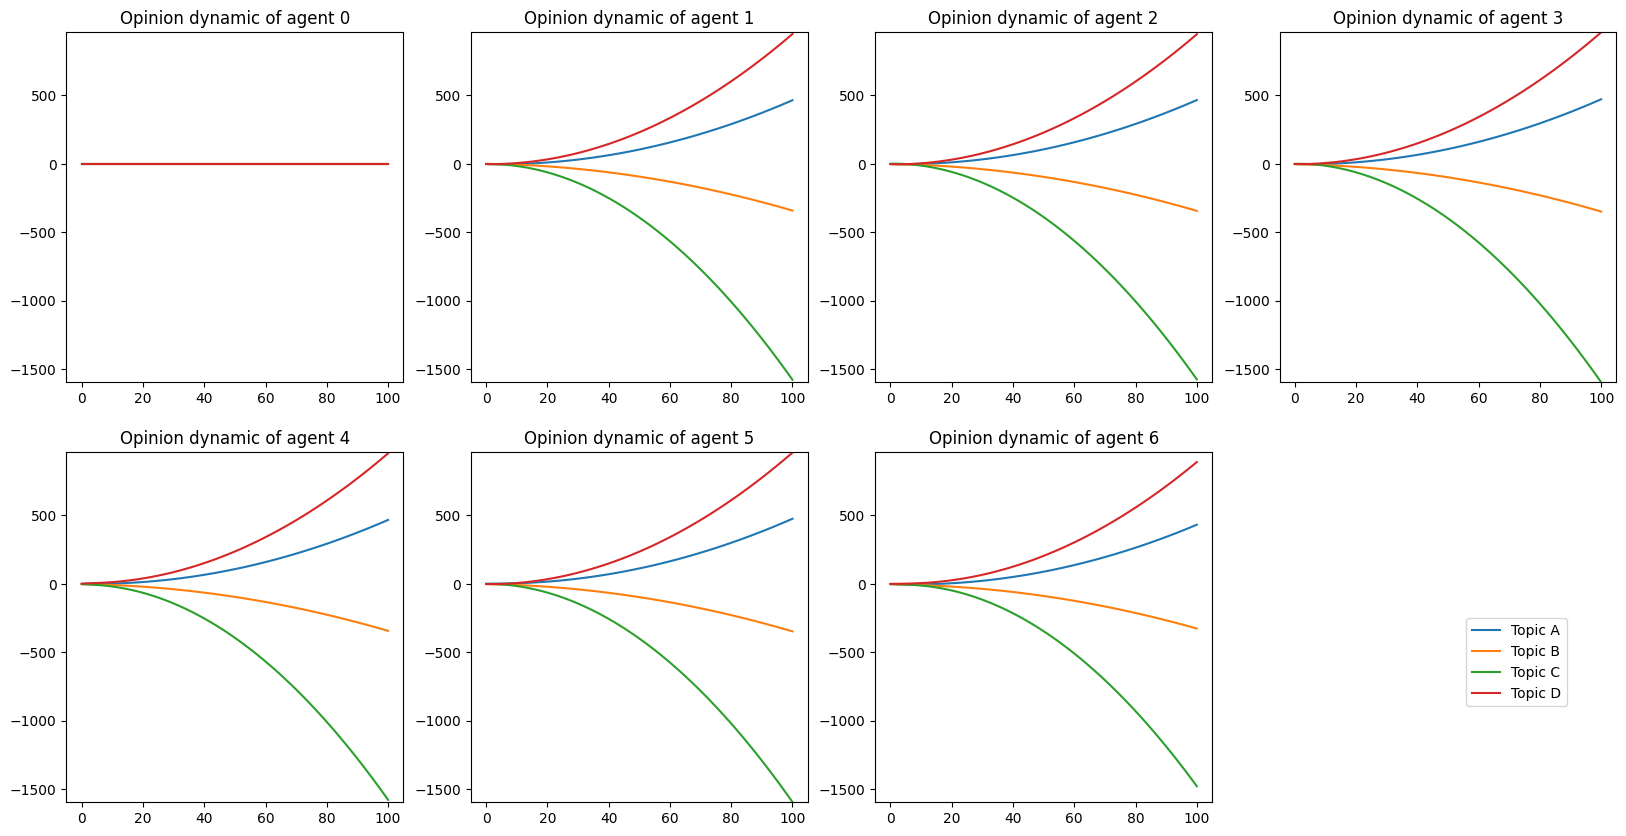

In [11]:
opinion_trajectory_plot(trajectories_3, dynamic.time_points, sheaf.d, range(sheaf.V),)

### Weighted reluctance: augmenting the network with stubborn parents 

In [29]:
sheaf = SheafBuilder(7, 3)
sheaf.augmentedConstantSheaf(gamma = 0.01)

x0 = sheaf.augmented_initial_state()

In [30]:
dynamic = SheafDynamic(
    sheaf.L_f, 
    sheaf.B, 
    0.1, 
    0.5, 
    sheaf.edges, 
    sheaf.V, 
    sheaf.d, 
    x0,
    U = sheaf.nodes[int(len(sheaf.nodes)/2):])

In [31]:
trajectories_4 = dynamic.privateOpinionDynamicSolver()

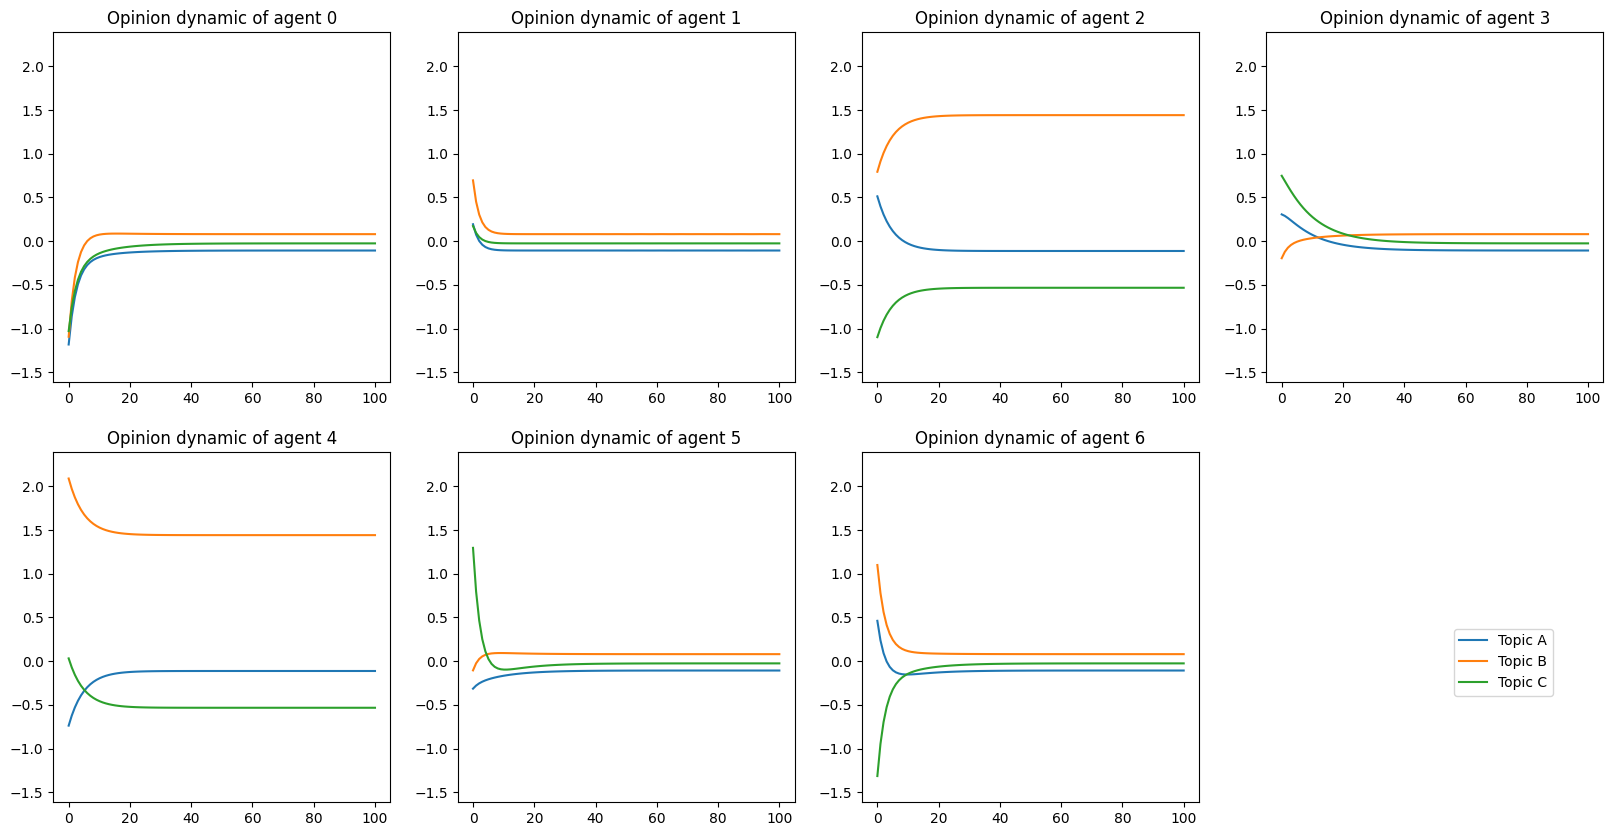

In [32]:
opinion_trajectory_plot(trajectories_4, dynamic.time_points, sheaf.d, range(sheaf.V),)

### Expression diffusion for "learning to lie" dynamics

In [17]:
# Let's generate a toy topology for our example

nodes = [i for i in range(7)]
edges = [
    (0,1),
    (0,3),
    (0,6),
    (1,2),
    (1,5),
    (2,4),
    (4,6),
    (5,6)
]

V = 7
E = len(edges)

d = 1                                           # Node and edges stalks dimension

F = {
    e:{
        e[0]:np.random.randn(d,d),
        e[1]:np.random.randn(d,d)
        } 
        for e in edges
    }                                           # Incidency linear maps

# Sheaf representation 

# Coboundary map

B = np.zeros((d*E, d*V))

for i in range(len(edges)):
    edge = edges[i]

    u = edge[0] 
    v = edge[1] 

    B_u = F[edge][u]
    B_v = F[edge][v]

    B[i*d:(i+1)*d, u*d:(u+1)*d] = np.ones((d,d))
    B[i*d:(i+1)*d, v*d:(v+1)*d] = - np.ones((d,d))

# Sheaf Laplacian

L_f = B.T @ B

In [18]:
def expressionDynamic(
        t, 
        B_flatten, 
        P,
        E,
        V, 
        d, 
        beta, 
        x0
        ):
    
    B = B_flatten.reshape(E*d,V*d)
    dt_dB = (- beta * P * (B @ np.outer(x0, x0)))
    return dt_dB.flatten()

def expressionDynamicSolver(
        B0, 
        x0, 
        E,
        V,
        d,
        beta = 0.1,
        T = 100,
        time_span = 100
        ):

    time_points = np.linspace(0, T, time_span)

    # Projector to preserve coboundary map sparsity structure
    P = (B0 != 0).astype('int32')

    solution = solve_ivp(
        expressionDynamic, 
        [0, 100], 
        B0.flatten(), 
        t_eval=time_points, 
        args=(P, E, V, d, beta, x0,),
        method='RK45'
        )
    
    B_hat = solution.y[:,-1].reshape(E*d, V*d)
    
    # Tracker of the disagreement 
    Bs = solution.y.T.reshape(time_points.shape[0], E*d, V*d)
    disagreement = x0.T @ (Bs.transpose(0,2,1) @ Bs.transpose(0,1,2)) @ x0

    return B_hat, disagreement

In [19]:
B0 = np.copy(B)
x0 = np.random.randn(V*d)

B_hat, disagreement = expressionDynamicSolver(B0, x0, E, V, d)

In [20]:
B_hat

array([[-0.20423072, -0.44217745,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.59713565,  0.        ,  0.        ,  0.20018282,  0.        ,
         0.        ,  0.        ],
       [-0.15140044,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.77193353],
       [ 0.        ,  0.00324331, -0.38736602,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.74102648,  0.        ,  0.        ,  0.        ,
         0.16476028,  0.        ],
       [ 0.        ,  0.        ,  1.17921134,  0.        , -0.30364717,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.14208508,
         0.        , -0.79551033],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.08526521, -0.89681814]])

In [21]:
L_hat = B_hat.T @ B_hat

In [22]:
x0.T @ L_f @ x0

21.882615317103078

In [23]:
x0.T @ L_hat @ x0

0.008036635050849894

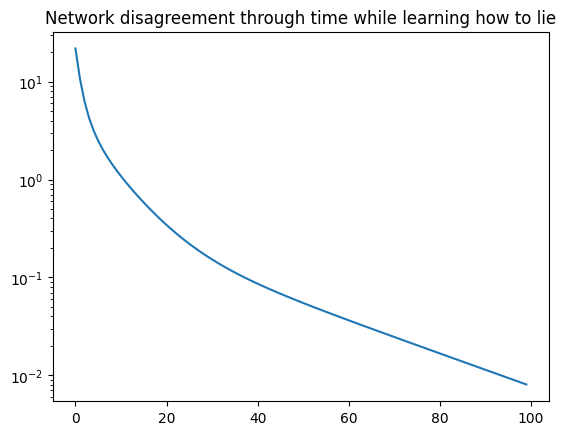

In [24]:
plt.plot(disagreement)
plt.title('Network disagreement through time while learning how to lie')
plt.yscale('log')